# Workshop 8. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [27]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import seaborn as sns
import numpy as np

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories =('alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'))
newsgroups_train.target_names

In [5]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=('alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'))

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [6]:
X_train = newsgroups_train.data
X_test = newsgroups_test.data
y_train = newsgroups_train.target
y_test = newsgroups_test.target

Выведите по 1 тексту для каждой из категории.

In [7]:
for cat in ('alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'):
    print(cat)
    print(fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories = [cat] ).data[0])
    print("\n")

alt.atheism


Ideologies also split, giving more to disagree upon, and may also lead
to intolerance.  So do you also oppose all ideologies?

I don't think your argument is an argument against religion at all, but
just points out the weaknesses of human nature.


I would like a reference if you have got one, for this is news to me.


One must approach the Qur'an with intelligence.  Any thinking approach
to the Qur'an cannot but interpret the above verse and others like it
that women and men are spiritual equals.

I think that the above verse does clearly imply that women have
souls.  Does it make any sense for something without a soul to be
forgiven?  Or to have a great reward (understood to be in the
after-life)?  I think the usual answer would be no -- in which case, the
part saying "For them has God prepared forgiveness and a great reward"
says they have souls.  

(If it makes sense to say that things without souls can be forgiven, then 
I have no idea _what_ a soul is.)

As for your

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words = 'english')
vectorizer.fit(X_train + X_test)
len(vectorizer.vocabulary_)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [13]:
nb = MultinomialNB()

In [18]:
nb.fit(X_train_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

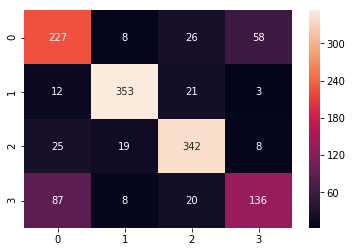

In [21]:
cross_val_score(nb, X_train_vec, y=y_train, cv = 5)

y_pred = nb.predict(X_test_vec)
matr = confusion_matrix(y_test, y_pred)

sns.heatmap(matr, annot = True, fmt = "d")

In [26]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(nb, vectorizer, newsgroups_train.target_names)

alt.atheism: [like believe say atheism does just think don people god]
comp.graphics: [software images files data use file jpeg edu graphics image]
sci.space: [just shuttle time orbit data like earth launch nasa space]
talk.religion.misc: [say know christian think just bible don jesus people god]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [29]:
tf_idf = TfidfVectorizer(stop_words="english", ngram_range = (0, 5))
tf_idf.fit(X_train + X_test)

X_train_vec = tf_idf.transform(X_train)
X_test_vec = tf_idf.transform(X_test)

In [30]:
nb.fit(X_train_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [32]:
cross_val_score(nb, X_train_vec, y = y_train, cv = 5)

array([0.625     , 0.64460784, 0.62162162, 0.63793103, 0.6345679 ])

In [31]:
show_top10(nb, tf_idf, newsgroups_train.target_names)

alt.atheism: [religion deletion atheism say think just don people god ]
comp.graphics: [hi does program know image file files thanks graphics ]
sci.space: [think lunar launch just orbit moon like nasa space ]
talk.religion.misc: [just don objective bible christians christian people jesus god ]


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ: ???

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.